# SmartSort Model
This model performs a process for data augmentation, and training a convolutional neural network (CNN) using Transfer Learning using VGG16 and MobileNetV2 on image data for classifying waste images into recyclable and organic.



## Upload file by mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/mntDrive')

Mounted at /mntDrive


In [2]:
# load data from google drive and unzip it

!unzip -q /mntDrive/MyDrive/ICT619-Dataset/archive.zip -d data

## Importing Libraries

In [16]:
import os
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten, Rescaling
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from keras.metrics import Precision, Recall

## Define dataset paths

In [17]:
### Google Colab Setup ###
# train_dir = '/content/data/DATASET/TRAIN'
# test_dir = '/content/data/DATASET/TEST'

### Local Setup ###
train_dir = 'C:\\Users\\pooja\\Downloads\\archive\\DATASET\\TRAIN'
test_dir = 'C:\\Users\\pooja\\Downloads\\archive\\DATASET\\TEST'

## Data Analysis

The dataset contains images divided into training and test sets all in jpg format. Therefore, no data labeling was required as the images were already labelled into two categories 'R' and 'O', recyclable and Organic, respectively.

In [18]:
class_names = os.listdir((train_dir))
print(f'Number of categories: {len(class_names)}')
print(f'Names of categories: {class_names}')

Number of categories: 2
Names of categories: ['O', 'R']


In [19]:
def count_images(directory, classes):
    return {class_name: len(glob(os.path.join(directory, class_name, '*'))) for class_name in classes}

count_train = count_images(train_dir, class_names)
count_test = count_images(test_dir, class_names)

total_train_images = sum(count_train.values())
total_test_images = sum(count_test.values())

print(f'Total number of images in train set: {total_train_images}')
print(f'Total number of images in test set: {total_test_images}')

Total number of images in train set: 22564
Total number of images in test set: 2513


Plotting number of images in train set:

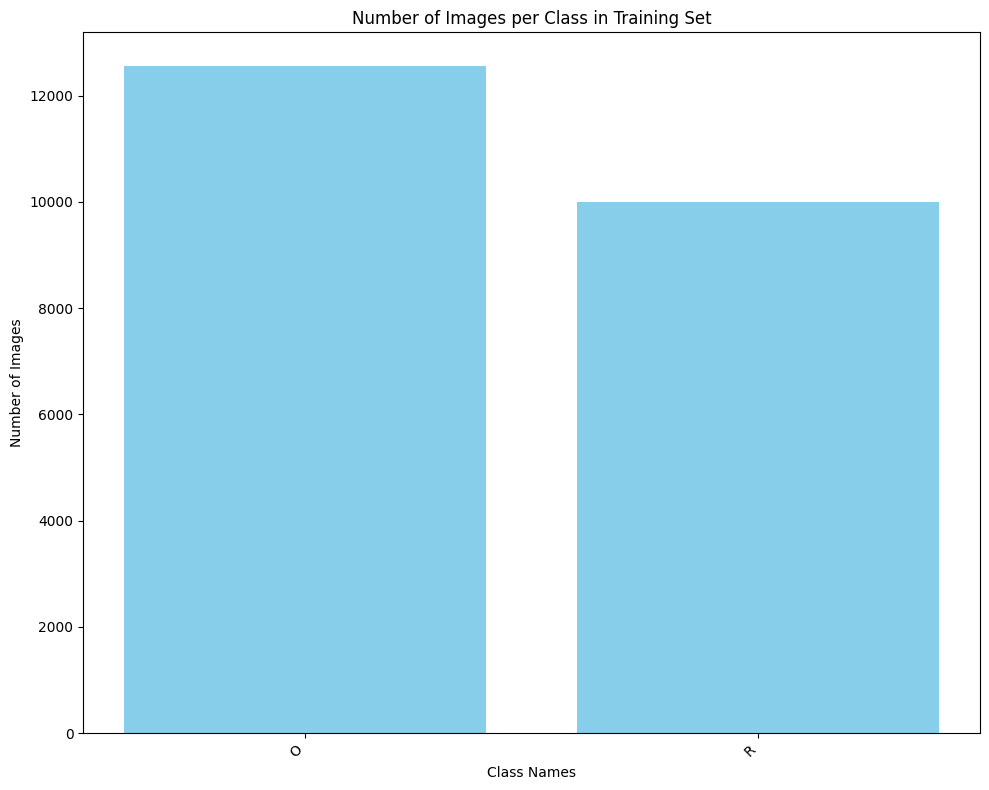

In [20]:
classes = list(count_train.keys())  # Extract class names
train_counts = [count_train[class_name] for class_name in classes]  # Extract counts for each class

plt.figure(figsize=(10, 8))  # Optional: Adjusts the figure size
plt.bar(classes, train_counts, color='skyblue')  # Creates the bar plot
plt.xlabel('Class Names')  # X-axis label
plt.ylabel('Number of Images')  # Y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate class names for better readability
plt.title('Number of Images per Class in Training Set')  # Chart title
plt.tight_layout()  # Adjust layout to not cut off labels

plt.show()  # Display the plot

Plotting number of images in the test set:

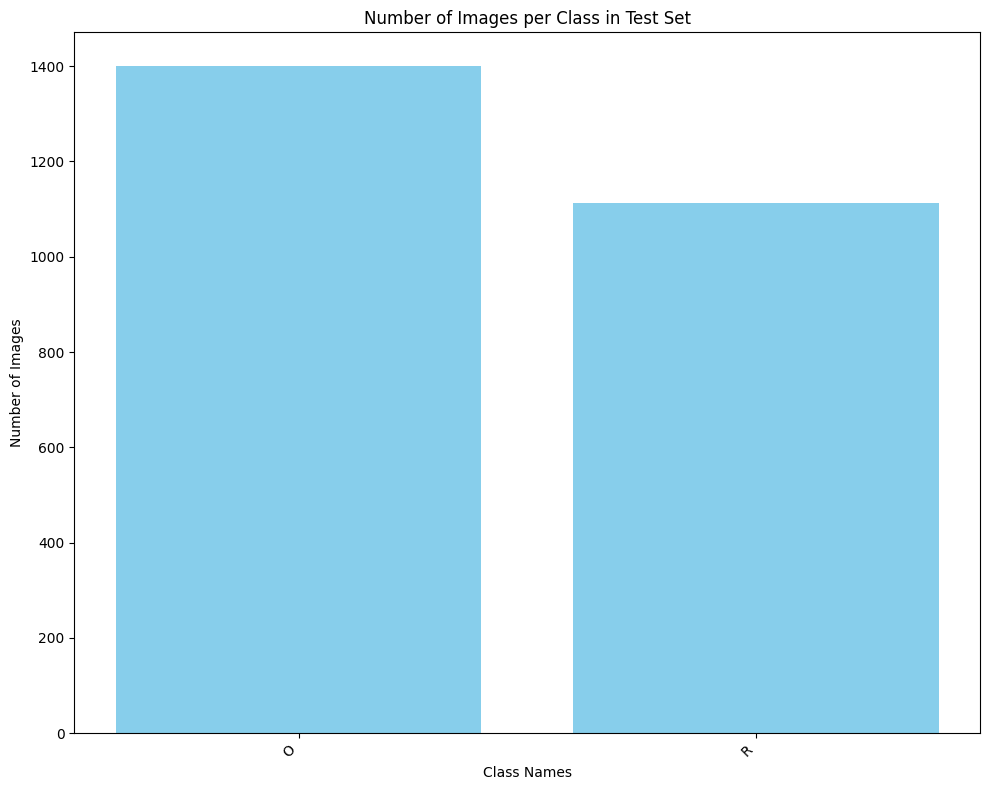

In [21]:
classes = list(count_test.keys())  # Extract class names
train_counts = [count_test[class_name] for class_name in classes]  # Extract counts for each class

plt.figure(figsize=(10, 8))  # Optional: Adjusts the figure size
plt.bar(classes, train_counts, color='skyblue')  # Creates the bar plot
plt.xlabel('Class Names')  # X-axis label
plt.ylabel('Number of Images')  # Y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate class names for better readability
plt.title('Number of Images per Class in Test Set')  # Chart title
plt.tight_layout()  # Adjust layout to not cut off labels

plt.show()  # Display the plot

## Data preparation

We perform data augmentation on our dataset. To develop a transformation that rescales the images and applies data augmentation, we utilized ImageDataGenerator. We only augment the training data. The validation data is only rescaled.

In [22]:
train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)


Now we split the data into training and test sets and change the image size to 224.

In [23]:
batch_size = 32
image_size = (224, 224)

train_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = image_size,
                                                 batch_size = batch_size,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = image_size,
                                            batch_size = batch_size,
                                            class_mode = 'binary')

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [10]:
train_set.class_indices

{'O': 0, 'R': 1}

In [11]:
train_set.image_shape

(224, 224, 3)

In [12]:
test_set.image_shape

(224, 224, 3)

Visualizing sample images from the training set:

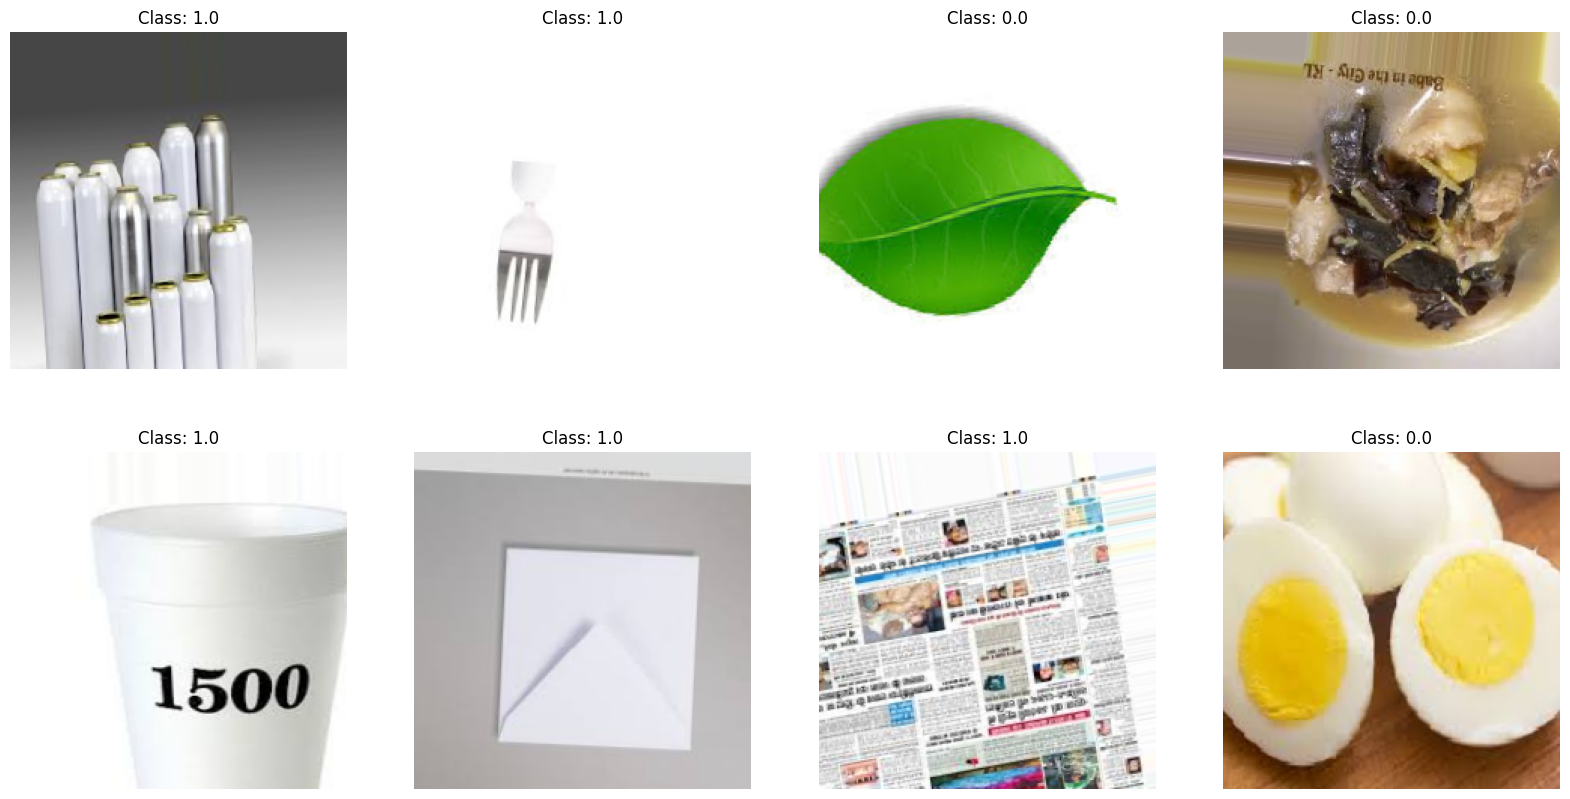

In [24]:
# Generate a batch of images
batch = next(train_set)

# Define the number of images to display
num_images = 8

plt.figure(figsize=(20, 10))
for i in range(num_images):
    # Get an image and its label from the batch
    img = batch[0][i]
    label = batch[1][i]
    
    # Plot the image
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f'Class: {label}')
    plt.axis('off')

plt.show()

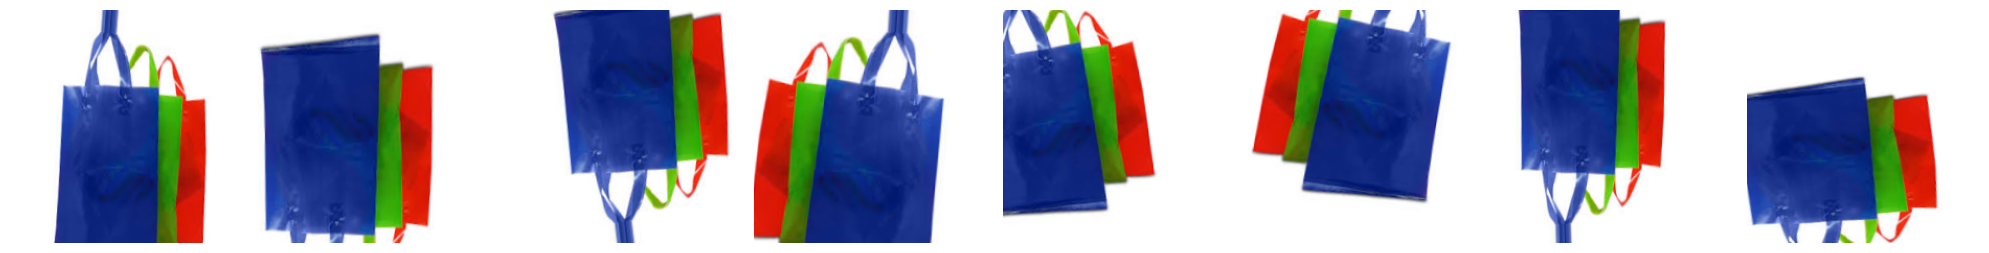

In [25]:
# Fetch a batch
batch = next(train_set)
# Select the first image and label from the batch
img, label = batch[0][0], batch[1][0]

# Function to plot images
def plot_images(image, num_images=8):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    axes = axes.flatten()
    for ax in axes:
        # Apply transformation - simulates augmentation by calling .random_transform()
        # It applies the transformation defined in train_datagen to the image
        augmented_img = train_datagen.random_transform(image)
        
        ax.imshow(augmented_img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plotting augmented versions of the first image
plot_images(img)

## Model Building

Building the CNN model architecture. It starts with building a model by using transfer learning with pre-trained VGG16 & MobileNetV2 models.

In [26]:
image_shape = (224, 224, 3)

vgg = tf.keras.applications.VGG16(input_shape=image_shape,
                                         include_top=False,
                                         weights='imagenet')

mobileNet = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                         include_top=False,
                                         weights='imagenet')

Next, we freeze the CNN layers to use the base model as the feature extractor:

In [27]:
for layer in vgg.layers:
  layer.trainable = False

for layer in mobileNet.layers:
  layer.trainable = False

## Building Model 1

The model 1 consists of Flatten layer, then we added two Dense layers with one Dropout layer as well.

In [28]:
input_layer = tf.keras.Input(shape=(224, 224, 3))

# Use the VGG model as a layer in a functional manner
x = vgg(input_layer)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Adjusted to match your dropout rate
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create a new model
model1 = tf.keras.Model(inputs=input_layer, outputs=output_layer)

### Compile the Model1

The model is compiled with the Adam optimizer and binary crossentropy loss function, which is appropriate for binary classification tasks. The model's performance will be evaluated based on accuracy.

In [29]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Training Model 1

Finally, the model is trained for a defined number of epochs using the training dataset, with validation performed on the validation dataset. The 'fit' method returns a history object containing training and validation loss and accuracy for each epoch, which can be used for analysis of the model's performance over time.

In [30]:
steps_per_epoch = int(len(train_set)/batch_size)

tf.random.set_seed(42)

history = model1.fit(train_set,
                     validation_data=test_set,
                     steps_per_epoch=steps_per_epoch,
                     epochs = 10,
                     verbose = 1)

Epoch 1/10


C:\Users\pooja\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 197s 9s/step - accuracy: 0.5318 - loss: 1.4263 - val_accuracy: 0.7573 - val_loss: 0.4956
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 483s 23s/step - accuracy: 0.6994 - loss: 0.5803 - val_accuracy: 0.8639 - val_loss: 0.3560
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 191s 9s/step - accuracy: 0.6792 - loss: 0.5510 - val_accuracy: 0.8715 - val_loss: 0.3314
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 192s 9s/step - accuracy: 0.7075 - loss: 0.4791 - val_accuracy: 0.8639 - val_loss: 0.4270
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 239s 11s/step - accuracy: 0.7353 - loss: 0.4891 - val_accuracy: 0.8691 - val_loss: 0.3525
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 182s 9s/step - accuracy: 0.7692 - loss: 0.5058 - val_accuracy: 0.8671 - val_loss: 0.3401
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 301s 14s/step - accuracy: 0.7412 - loss: 0.5059 - val_accuracy: 0.8703 - val_loss: 0.3458
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 223s 11s/step - accuracy: 0.7814 - loss: 0.4624 - val_accuracy: 0.8599 - val_loss

In [31]:
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       802,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,123,333 (65.32 MB)

 Trainable params: 802,881 (3.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 1,605,764 (6.13 MB)

### Evaluating the performance of model 1

In [33]:
loss, accuracy = model1.evaluate(test_set, verbose=False)
print("Test Accuracy: {:.4f}".format(accuracy))

Test Accuracy: 0.8571


### Visualizing training results for model 1

The plots of loss and accuracy on the training and validation sets.

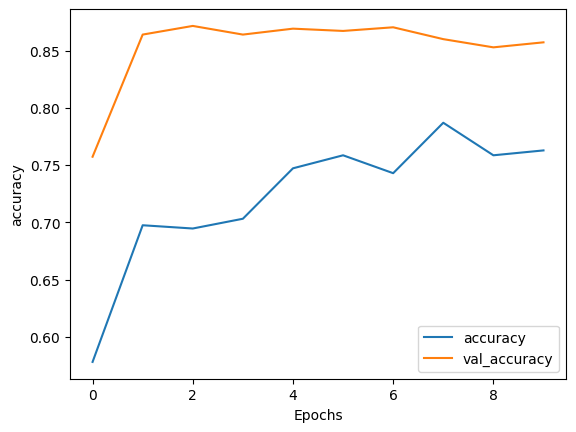

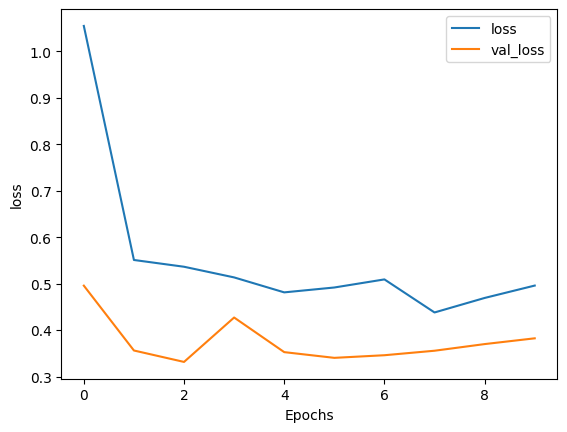

In [34]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Building Model 2

In [37]:
x = mobileNet(input_layer)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create a new model
model2 = tf.keras.Model(inputs=input_layer, outputs=output_layer)

### Compiling Model 2

In [38]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Training Model 2

In [39]:
history1 = model2.fit(train_set,
                     validation_data=test_set,
                     steps_per_epoch=steps_per_epoch,
                     epochs = 10,
                     batch_size=32,
                     verbose = 1)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.6442 - loss: 2.7011 - val_accuracy: 0.8870 - val_loss: 0.3375
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.8211 - loss: 0.4621 - val_accuracy: 0.8508 - val_loss: 0.3676
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.8426 - loss: 0.3295 - val_accuracy: 0.7967 - val_loss: 0.4727
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.8881 - loss: 0.2666 - val_accuracy: 0.8731 - val_loss: 0.3115
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.8144 - loss: 0.3811 - val_accuracy: 0.8221 - val_loss: 0.4835
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.8525 - loss: 0.3284 - val_accuracy: 0.9057 - val_loss: 0.3329
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.8192 - loss: 0.3267 - val_accuracy: 0.8894 - val_loss: 0.3937
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.8586 - loss: 0.3046 - val_accuracy: 0.9041 - val_loss:

### Evaluating Model 2

In [40]:
loss, accuracy = model2.evaluate(test_set, verbose=False)
print("Test Accuracy: {:.4f}".format(accuracy))

Test Accuracy: 0.8926


### Visualizing training results for model 2

The plots of loss and accuracy on the training and validation sets.

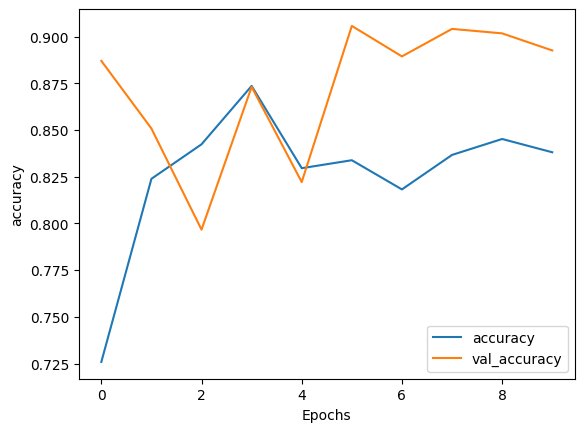

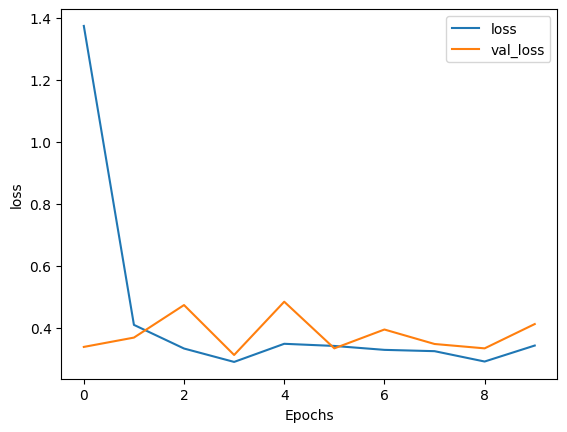

In [41]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history1, "accuracy")
plot_graphs(history1, "loss")

## Validating the models

Validating the models to check if they can accurately classify some of the unseen images.

In [42]:
# Function to prepare and predict the class of an image
def predict_with_augmentation(img_path, model):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))

    plt.axis("off")
    plt.imshow(img)
    plt.show()

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Expand dimensions to match the shape of model input
    img_array = np.expand_dims(img_array, axis=0)

    # Predict (data augmentation is applied automatically)
    prediction = model.predict(img_array)

    print(prediction)

    if prediction[0][0] == 1:
      predicted_class = 'Recyclable Waste'
    else:
      predicted_class = 'Organic Waste'

    return predicted_class

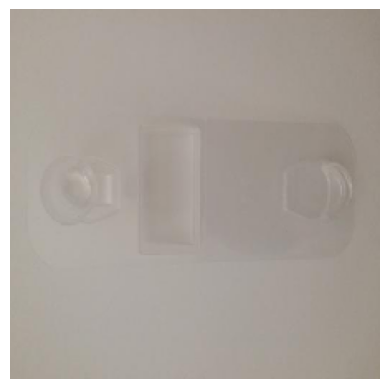

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
[[1.]]
Predicted: Recyclable Waste


In [47]:
img_path = 'C:\\Users\\pooja\\Downloads\\recycling waste-20240329T123018Z-001\\recycling waste\\plastic\\plastic2.jpg'
#img_path = 'C:\\Users\\pooja\\Downloads\\dustbin.jpg'
predicted_class = predict_with_augmentation(img_path, model1)
print(f'Predicted: {predicted_class}')

In [50]:
model1.save("web-app/tf_model_1.keras")
model2.save("web-app/tf_model_2.keras")